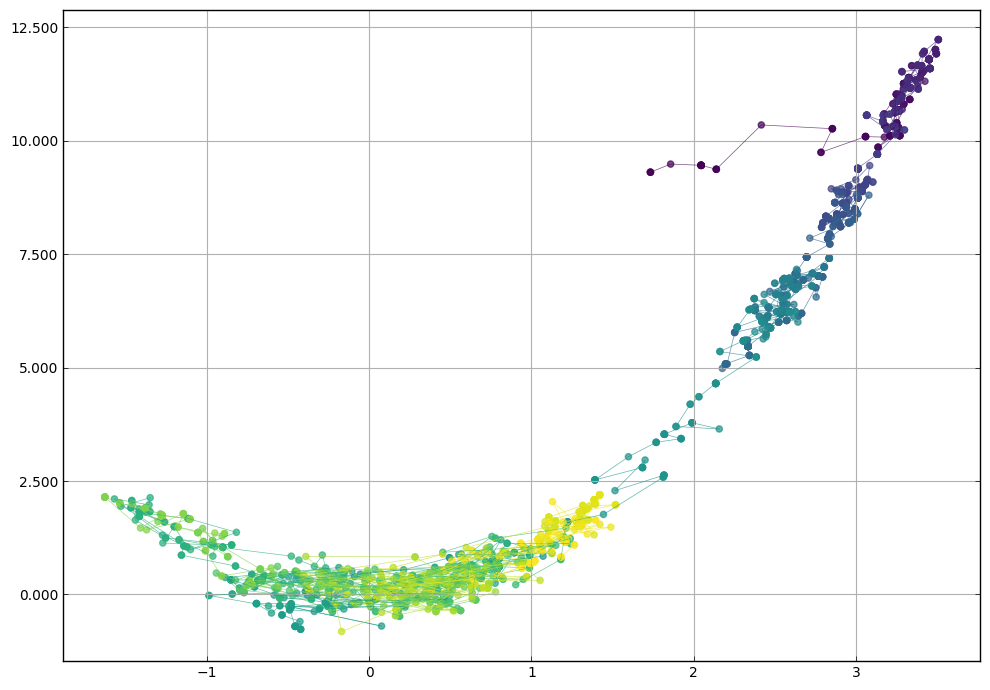

In [3]:
import numpy as np
from   numpy.random import multivariate_normal as mvn
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.rcParams['font.family'] ='sans-serif'#使用するフォント
plt.rcParams['xtick.direction'] = 'in'#x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in'#y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = .5 #x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = .5 #y軸主目盛り線の線幅
plt.rcParams['font.size'] = 10 #フォントの大きさ
plt.rcParams['axes.linewidth'] = 1.0# 軸の線幅edge linewidth。囲みの太さ



n_iters    = 2000
samples    = np.empty((n_iters, 2))
samples[0] = np.random.uniform(low=[-3, -3], high=[3, 10], size=2)
rosen      = lambda x, y: np.exp(-((1 - x)**2 + 100*(y - x**2)**2) / 20)

for i in range(1, n_iters):
    curr  = samples[i-1]
    prop  = curr + mvn(np.zeros(2), np.eye(2) * 0.1)
    alpha = rosen(*prop) / rosen(*curr)
    if np.random.uniform() < alpha:
        curr = prop
    samples[i] = curr

plt.figure(figsize=(10, 7))
#plt.figure(figsize=(3.14,3.14))
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))#y軸小数点以下3桁表示
plt.gca().xaxis.get_major_formatter().set_useOffset(False)
# plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.locator_params(axis='y',nbins=6)#y軸，6個以内．
plt.gca().yaxis.set_tick_params(which='both', direction='in',bottom=True, top=True, left=True, right=True)
#plt.tight_layout()#グラフが重ならず，設定した図のサイズ内に収まる。
#plt.savefig('figname.pdf', transparent=True)
#plt.savefig('figname.png', transparent=True, dpi=300)

#plt.contour(X, Y, Z, cmap='viridis') # viridisの配色で等高線を描く

# カラーマップの作成
colors = cm.viridis(np.linspace(0, 1, n_iters))

# サンプルの点をプロット
plt.scatter(samples[:, 0], samples[:, 1], c=colors, s=20, alpha=0.7)

# サンプルの点を線で繋ぐ
for i in range(1, n_iters):
    plt.plot(samples[i-1:i+1, 0], samples[i-1:i+1, 1], color=colors[i], alpha=0.7, lw=0.5)

plt.grid()
plt.tight_layout()
plt.show()

In [4]:

import matplotlib.pyplot as plt
import numpy as np
from   numpy.linalg import inv
import numpy.random as npr
from   pypolyagamma import PyPolyaGamma
from scipy.stats import multivariate_normal

# シグモイド関数
def sigmoid(x):
    """Numerically stable sigmoid function.
    """
    return np.where(x >= 0, 
                    1 / (1 + np.exp(-x)),
                    np.exp(x) / (1 + np.exp(x)))

def multi_pgdraw(pg, B, C):
    """Utility function for calling `pgdraw` on every pair in vectors B, C.
    """
    return np.array([pg.pgdraw(b, c) for b, c in zip(B, C)])


# 1次元のロジスティック回帰モデル
def gen_bimodal_data(N, p):
    """Generate bimodal data for easy sanity checking.
    """
    y     = npr.random(N) < p
    X     = np.empty(N)
    X[y]  = npr.normal(0, 1, size=y.sum())
    X[~y] = npr.normal(4, 1.4, size=(~y).sum())
    return X, y.astype(int)


# Set priors and create data.
N_train = 1000
N_test  = 1000
b       = np.zeros(2)
B       = np.diag(np.ones(2))
X_train, y_train = gen_bimodal_data(N_train, p=0.3)
X_test, y_test   = gen_bimodal_data(N_test, p=0.3)
# Prepend 1 for the bias β_0.
X_train = np.vstack([np.ones(N_train), X_train])
X_test  = np.vstack([np.ones(N_test), X_test])



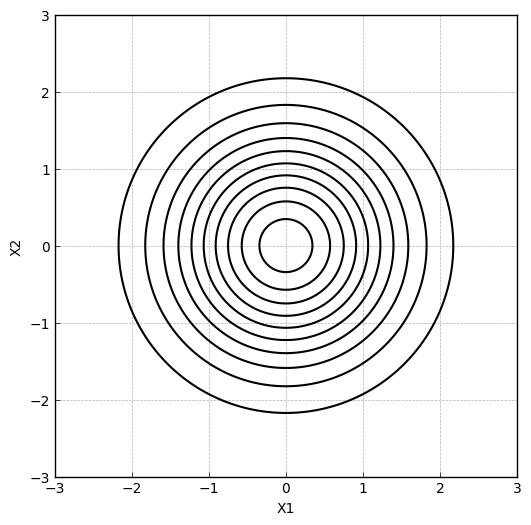

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# 平均ベクトルと共分散行列の設定
b = np.zeros(2)
B = np.diag(np.ones(2))

# グリッドの生成
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))

# 多変量正規分布の定義
rv = multivariate_normal(mean=b, cov=B)

# 等高線プロットの作成
plt.figure(figsize=(6, 6))
plt.contour(x, y, rv.pdf(pos), levels=10, colors='black')
plt.xlabel('X1')
plt.ylabel('X2')
plt.xticks(np.arange(-3, 4, 1))
plt.yticks(np.arange(-3, 4, 1))
plt.grid(True, linestyle='--', linewidth=0.5)  # グリッド線を追加
plt.gca().set_aspect('equal', adjustable='box')  # アスペクト比を1:1に設定
plt.show()


  0%|          | 49/10000 [00:00<00:20, 483.76it/s]

100%|██████████| 10000/10000 [00:22<00:00, 451.87it/s]


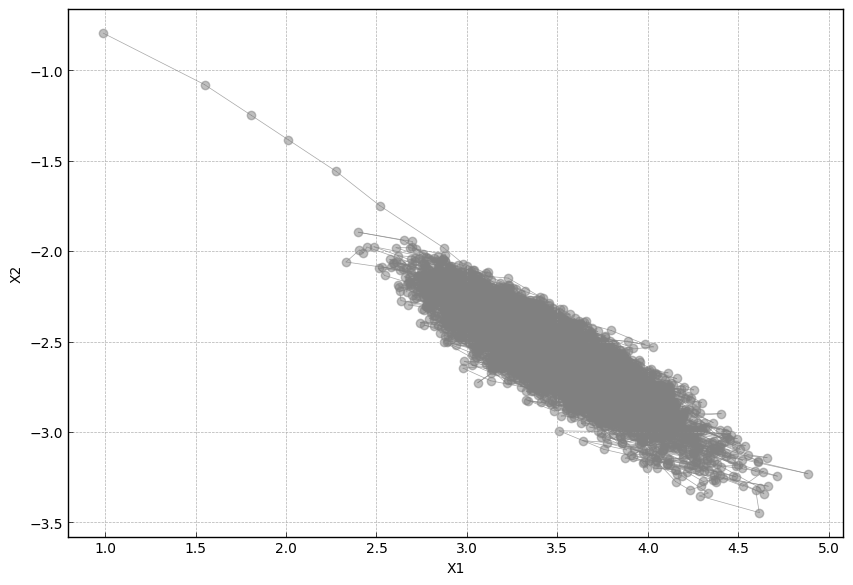

In [6]:
import matplotlib.cm as cm
from tqdm import tqdm

# Peform Gibbs sampling for T iterations.
pg         = PyPolyaGamma()
T          = 10000
Omega_diag = np.ones(N_train)
beta_hat   = npr.multivariate_normal(b, B)
k          = y_train - 1/2.

beta_list = []
for _ in tqdm(range(T)):
    # ω ~ PG(1, x*β).
    Omega_diag = multi_pgdraw(pg, np.ones(N_train), X_train.T @ beta_hat)
    # β ~ N(m, V).
    V         = inv(X_train @ np.diag(Omega_diag) @ X_train.T + inv(B))
    m         = np.dot(V, X_train @ k + inv(B) @ b)
    beta_hat  = npr.multivariate_normal(m, V)
    beta_list.append(beta_hat)
    
beta_list = np.array(beta_list)

# Plot the posterior distribution of β.
plt.figure(figsize=(10, 10))
# カラーマップの作成
colors = cm.viridis(np.linspace(0, 1, T))

plt.scatter(beta_list[:, 0], beta_list[:, 1], c="grey", alpha=0.5)

# サンプルの点を線で繋ぐ
for i in range(1, T):
    plt.plot(beta_list[i-1:i+1, 0], beta_list[i-1:i+1, 1], color="grey", alpha=0.7, lw=0.5)

plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True, linestyle='--', linewidth=0.5)  # グリッド線を追加
plt.gca().set_aspect('equal', adjustable='box')  # アスペクト比を1:1に設定
plt.show()


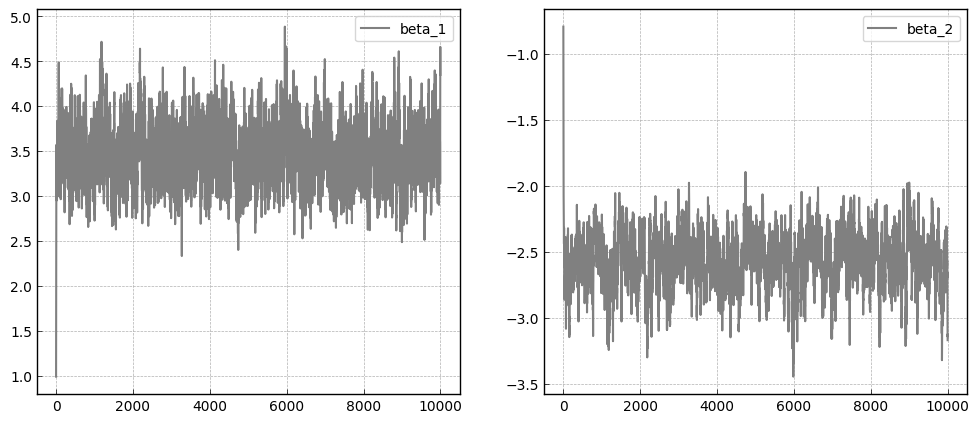

In [7]:
plt.figure(figsize=(12, 5))
#plt.title('Posterior Distribution of Beta')
# beta_list[:, 0]をTを横軸にしてプロット
plt.subplot(1, 2, 1)
plt.plot(beta_list[:, 0], c='grey', label='beta_1')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(beta_list[:, 1], c='grey', label='beta_2')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()

plt.show()

In [8]:
# バーンイン期間を15としてそれ以降の平均でMAP推定
beta_mpe = beta_list[15:].mean(axis=0)
beta_mpe

array([ 3.46717292, -2.56159026])

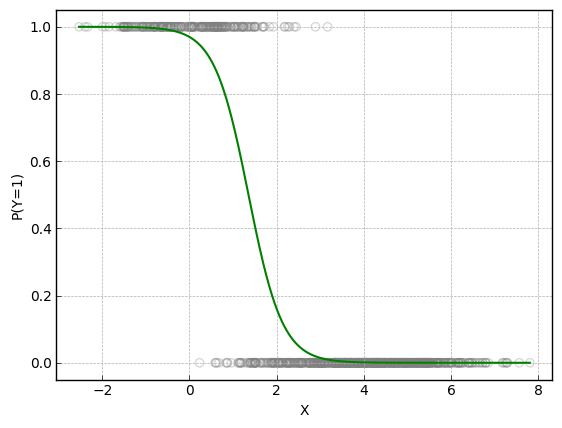

In [9]:
plt.scatter(X_train[1], y_train, facecolor='None', edgecolor='grey', marker='o', alpha=0.3, label='Observed Data')

x = np.linspace(X_train[1].min(), X_train[1].max(), 1000)
y = sigmoid(beta_mpe @ np.vstack([np.ones(1000), x]))
plt.plot(x, y, c='green', label='MPE Prediction')
plt.xlabel('X')
plt.ylabel('P(Y=1)')
plt.grid(True, linestyle='--', linewidth=0.5)

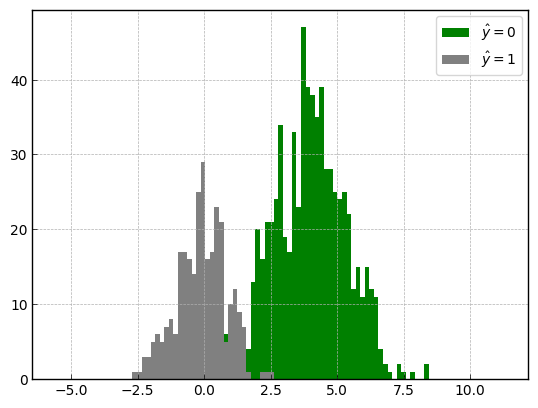

In [10]:


y_pred = npr.binomial(1, sigmoid(X_test.T @ beta_hat))
bins = np.linspace(X_test.min()-3., X_test.max()+3, 100)
plt.hist(X_test.T[y_pred == 0][:, 1],    color='green', bins=bins, label='$\hat{y}=0$')
plt.hist(X_test.T[~(y_pred == 0)][:, 1], color='grey', bins=bins, label='$\hat{y}=1$')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()

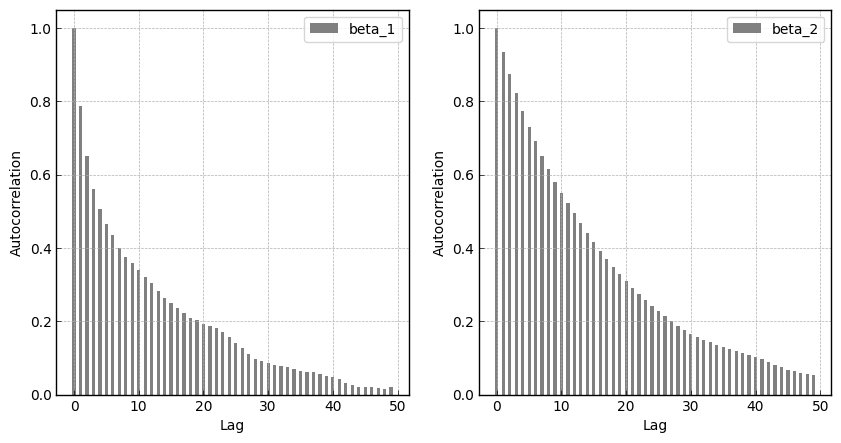

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

# 自己相関の計算
autocorrelation_1 = [pd.Series(beta_list[:, 0]).autocorr(lag=i) for i in range(50)]
autocorrelation_2 = [pd.Series(beta_list[:, 1]).autocorr(lag=i) for i in range(50)]

# 自己相関のプロット


plt.figure(figsize=(10, 5))
#plt.title('Autocorrelation of MCMC Samples of Beta')

plt.subplot(1, 2, 1)
plt.bar(range(50), autocorrelation_1, width=0.5, color='grey', label='beta_1')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(range(50), autocorrelation_2, width=0.5, color='grey', label='beta_2')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()

plt.show()



In [12]:
def lamda(x, beta):
    X = np.vstack([np.ones(x.shape), x, x**2]).T
    return np.exp(X@beta)

def sample_inhomogeneous_poisson_process(beta, T):
    # 最大強度を見つけるために、強度関数の最大値を計算
    x = np.linspace(0, T, 1000)
    max_lambda = np.max(lamda(x, beta))
    
    # サンプリングするイベントを格納するリスト
    events = []
    t = 0

    while t < T:
        # 次の候補イベントの間隔を指数分布からサンプリング
        u = np.random.uniform()
        t += -np.log(u) / max_lambda
        
        # 時刻 t での強度関数の値
        if t < T:
            lambda_t = lamda(np.array([t]), beta)
            
            # 強度関数の値に基づいてイベントを受け入れるか拒否するか決定
            if np.random.uniform() < lambda_t / max_lambda:
                events.append(t)
    
    return np.array(events)

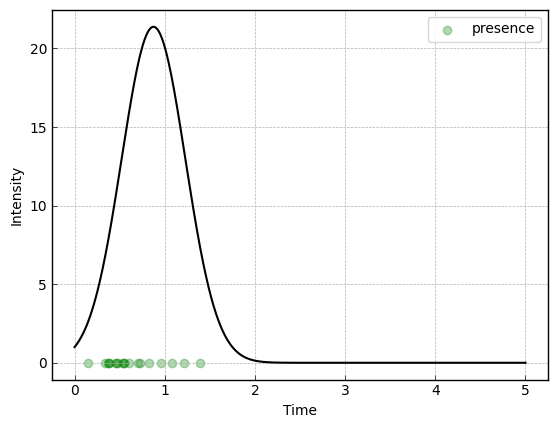

In [13]:
beta_true = np.array([0, 7, -4])
events = sample_inhomogeneous_poisson_process(beta_true, 5)

t1= np.array(events)
x_lin = np.linspace(0, 5, 1000)
intensity = lamda(x_lin, beta_true)
plt.scatter(t1, np.zeros(len(t1)), c='green', alpha=0.3, label='presence')
plt.plot(x_lin, intensity, c='black')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [14]:
import scipy
    
def generate_IPP(beta_true, n0, verbose=False):
    # 1次元の非斉次ポアソン過程モデル
    T = 5

    def lamda(x, beta):
        X = np.vstack([np.ones(x.shape), x, x**2]).T
        return np.exp(X@beta)

    x_lin = np.linspace(0, T, 1000)
    intensity = lamda(x_lin, beta_true)
    
    if verbose:
        plt.plot(x_lin, intensity, c='black')
        plt.xlabel('Time')
        plt.ylabel('Intensity')
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.show()

    # サンプリングするイベントを格納するリスト
    events = []
    t = 0
    
    max_lambda = np.max(intensity)

    while t < T:
        # 次の候補イベントの間隔を指数分布からサンプリング
        u = np.random.uniform()
        t += -np.log(u) / max_lambda
        
        # 時刻 t での強度関数の値
        if t < T:
            lambda_t = lamda(np.array([t]), beta_true)
            
            # 強度関数の値に基づいてイベントを受け入れるか拒否するか決定
            if np.random.uniform() < lambda_t / max_lambda:
                events.append(t)

    t1 = np.array(events)    

    n1 = len(t1)
    
    # background data: 一様分布からのサンプリング
    t0 = np.random.uniform(0, T, n0)

    if verbose:
        plt.scatter(t0, np.zeros(n0), c='grey', alpha=0.4, label='pseudo-absence')
        plt.scatter(t1, np.zeros(len(t1)), c='green', alpha=0.3, label='presence')
        plt.plot(x_lin, intensity, c='black')
        plt.xlabel('Time')
        plt.ylabel('Intensity')
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.legend()
        plt.show()

    n = n1 + n0
    t = np.concatenate([t1, t0])
    X = np.vstack([np.ones(n), t, t**2]).T
    y = np.concatenate([np.ones(n1), np.zeros(n0)]).astype(int)
    
    return X, y, t1, t0


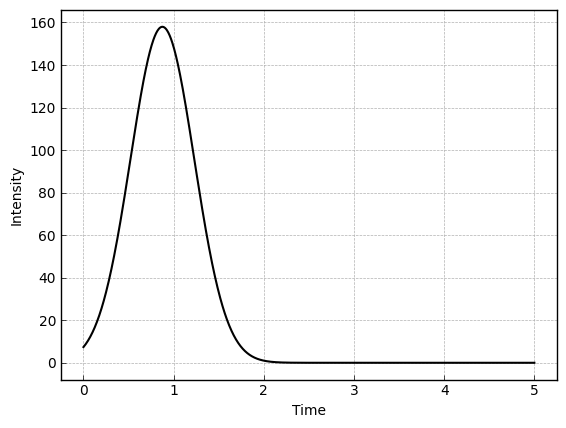

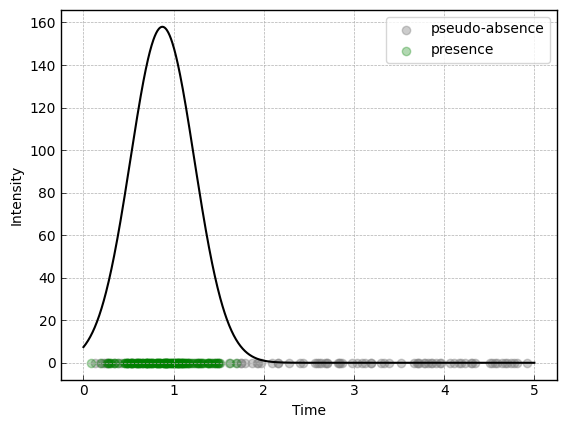

Number of presence: 135
Number of absence: 100


In [24]:



beta_true = np.array([2, 7, -4])
n0 = 100
Z = 1000

X, y, t1, t0 = generate_IPP(beta_true, n0, verbose=True)


print(f"Number of presence: {len(t1)}")
print(f"Number of absence: {len(t0)}")


In [25]:
import scipy.optimize as opt

# ロジスティック回帰モデルの最尤推定

def negative_log_likelihood(beta, X, y, z):
    h = sigmoid(X@beta)
    return -np.sum(y * np.log(h) + (1 - y) * z * np.log(1 - h))

z = np.concatenate([np.ones(len(t1)), np.ones(len(t0))*Z])
beta_hat = opt.fmin_bfgs(negative_log_likelihood, np.random.normal(size=3), args=(X, y, z))

beta_hat

         Current function value: 857.176611
         Iterations: 31
         Function evaluations: 173
         Gradient evaluations: 43


/tmp/ipykernel_2380107/865801438.py:7: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(h) + (1 - y) * z * np.log(1 - h))
/home/ohta/dev/bayesian_statistics/.venv/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/ohta/dev/bayesian_statistics/.venv/lib/python3.9/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


array([-8.94377141,  9.01244674, -4.90273775])

## 繰り返し推定して漸近的性質を確認

In [29]:
beta_true = np.array([2, 7, -4])

n0_candidates = np.array([10, 100, 1000, 10000])
Z_candidates = np.array([1, 10, 100, 1000, 10000, 100000])

n_estimate = 1000
beta_estimated = np.empty((n_estimate, len(n0_candidates), len(Z_candidates), 3))
n1_estimated = np.empty((n_estimate, len(n0_candidates), len(Z_candidates)))

"""
# warningを非表示
import warnings
warnings.filterwarnings('ignore')
for i in tqdm(range(n_estimate)):
    for j, n0 in enumerate(n0_candidates):
        X, y, t1, t0 = generate_IPP(beta_true, n0)
        for k, Z in enumerate(Z_candidates):
            z = np.concatenate([np.ones(len(t1)), np.ones(len(t0))*Z])    
            n1_estimated[i, j, k] = len(t1)
            beta_estimated[i, j, k] = opt.fmin_bfgs(negative_log_likelihood, np.random.normal(size=3), args=(X, y, z), disp=False)
"""

"\n# warningを非表示\nimport warnings\nwarnings.filterwarnings('ignore')\nfor i in tqdm(range(n_estimate)):\n    for j, n0 in enumerate(n0_candidates):\n        X, y, t1, t0 = generate_IPP(beta_true, n0)\n        for k, Z in enumerate(Z_candidates):\n            z = np.concatenate([np.ones(len(t1)), np.ones(len(t0))*Z])    \n            n1_estimated[i, j, k] = len(t1)\n            beta_estimated[i, j, k] = opt.fmin_bfgs(negative_log_likelihood, np.random.normal(size=3), args=(X, y, z), disp=False)\n"

In [30]:
beta_estimated = pd.read_csv('beta_estimated.csv', header=None).values.reshape(1000, 4, 6, 3)
beta_estimated.shape

(1000, 4, 6, 3)

In [31]:
beta_pred = beta_estimated[:, 1, 3, :]
beta_pred = beta_pred[np.all(np.abs(beta_pred) < 100, axis=1)]
beta_pred.shape

(895, 3)

ValueError: x must have 2 or fewer dimensions

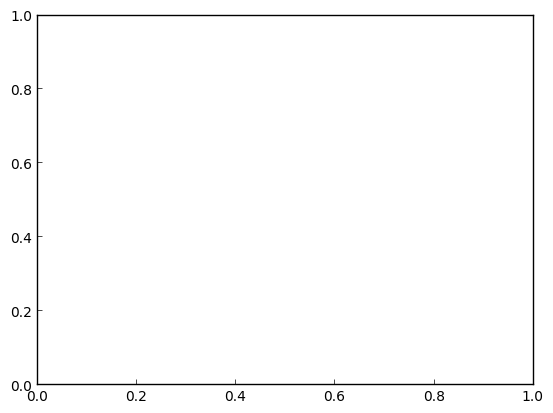

In [32]:
plt.hist(n1_estimated, bins=20, color='grey', alpha=0.5, density=True, label='Estimated')
n1_mean = n1_estimated.mean()
plt.vlines(n1_mean, 0, 1, color='green', label='Mean')
plt.ylim(0, 0.1)

# 平均がn1_meanのポアソン分布をプロット
x = np.arange(n1_estimated.min(), n1_estimated.max())
y = scipy.stats.poisson.pmf(x, n1_mean)
plt.plot(x, y, color='green', label='Poisson')

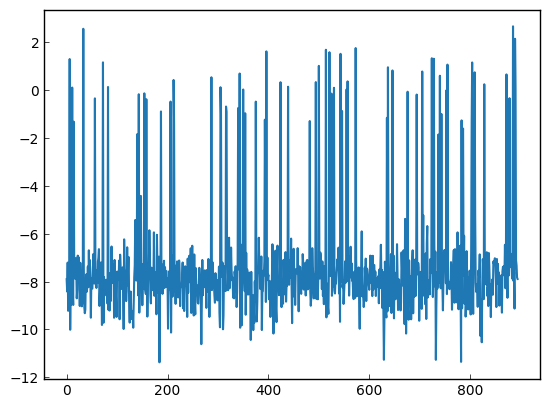

In [33]:
plt.plot(beta_pred[:, 0])

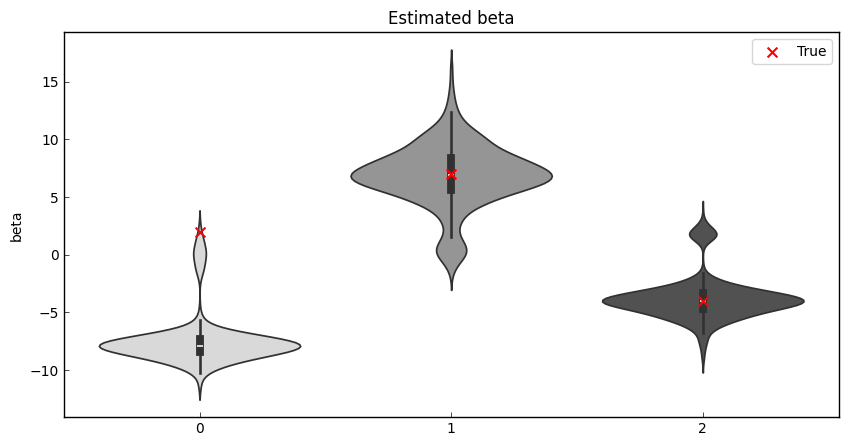

In [34]:
plt.figure(figsize=(10, 5))
# violinplot
import seaborn as sns
sns.violinplot(data=beta_pred, palette='Greys')
plt.scatter([0, 1, 2], beta_true, c='red', label='True', marker='x', s=50, zorder=10)

plt.title("Estimated beta")#グラフのタイトル
plt.ylabel('beta')#ｙ軸ラベル
plt.xlabel("")#x軸ラベルの消去
plt.legend()

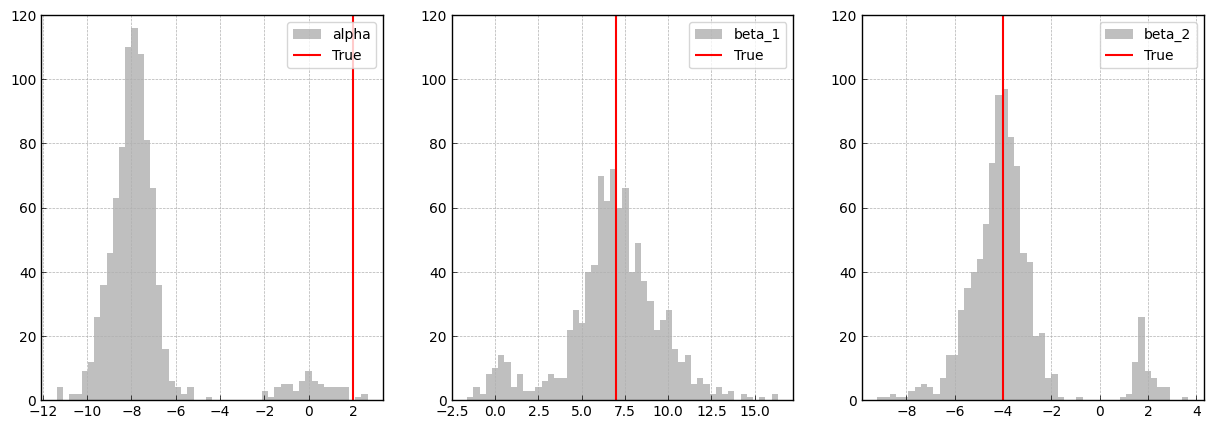

In [35]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(beta_pred[:, 0], bins=50, color='grey', alpha=0.5, label='alpha')
plt.vlines(beta_true[0], 0, 150, color='red', label='True')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.ylim(0, 120)
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(beta_pred[:, 1], bins=50, color='grey', alpha=0.5, label='beta_1')
plt.vlines(beta_true[1], 0, 150, color='red', label='True')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.ylim(0, 120)
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(beta_pred[:, 2], bins=50, color='grey', alpha=0.5, label='beta_2')
plt.vlines(beta_true[2], 0, 150, color='red', label='True')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.ylim(0, 120)
plt.legend()

In [36]:
beta_mean = beta_pred.mean(axis=0)
beta_mean

array([-7.40275797,  6.83990071, -3.77293366])

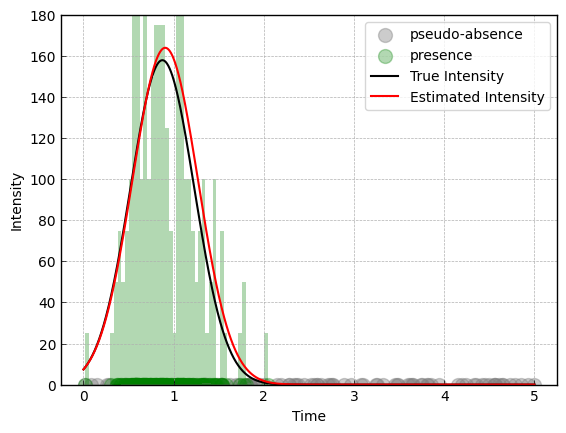

In [37]:
plt.scatter(t0, np.zeros(n0), c='grey', alpha=0.4, label='pseudo-absence', s=100)
plt.scatter(t1, np.zeros(len(t1)), c='green', alpha=0.3, label='presence', s=100)


plt.hist(t1, bins=50, color='green', alpha=0.3, weights=25*np.ones(len(t1)))
plt.hist(t0, bins=50, color='grey', alpha=0.3, weights=np.ones(len(t0))/10)
t_lin = np.linspace(0, 5, 1000)
X_lin = np.vstack([np.ones(1000), t_lin, t_lin**2]).T
plt.plot(t_lin, lamda(t_lin, beta_true), c='black', label='True Intensity')

#for beta in beta_pred:
#    plt.plot(t_lin, lamda(t_lin, beta), c='black', alpha=0.1)

beta_mean[0] = 2
plt.plot(t_lin, lamda(t_lin, beta_mean), c='red', label='Estimated Intensity')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.ylim(0, 180)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

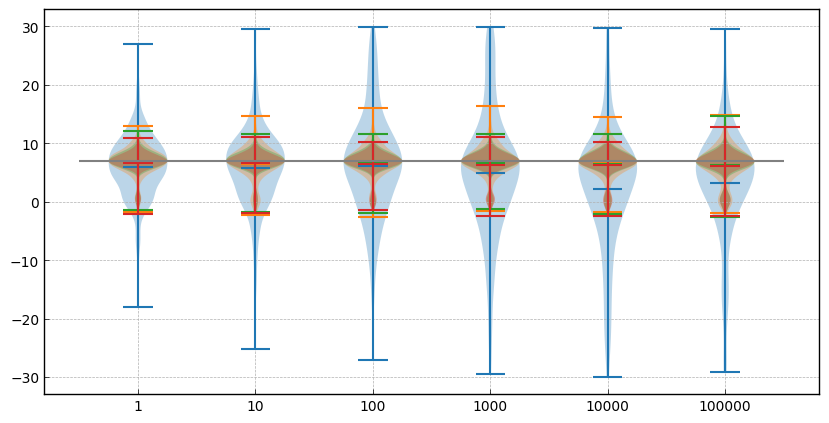

In [38]:

betas_list_list = []
for i in range(4):
    betas_list = []
    for j in range(6):
        betas = beta_estimated[:, i, j, 1]
        betas = betas[np.abs(betas) < 30]
        betas_list.append(betas)
    betas_list_list.append(betas_list)

plt.figure(figsize=(10, 5))
for i in range(4):
    plt.violinplot(betas_list_list[i], showmeans=True, showmedians=False)
    
plt.hlines(beta_true[1], 0.5, 6.5, color='grey', label='True')
plt.xticks([1, 2, 3, 4, 5, 6], Z_candidates)
plt.grid(True, linestyle='--', linewidth=0.5)

plt.show()

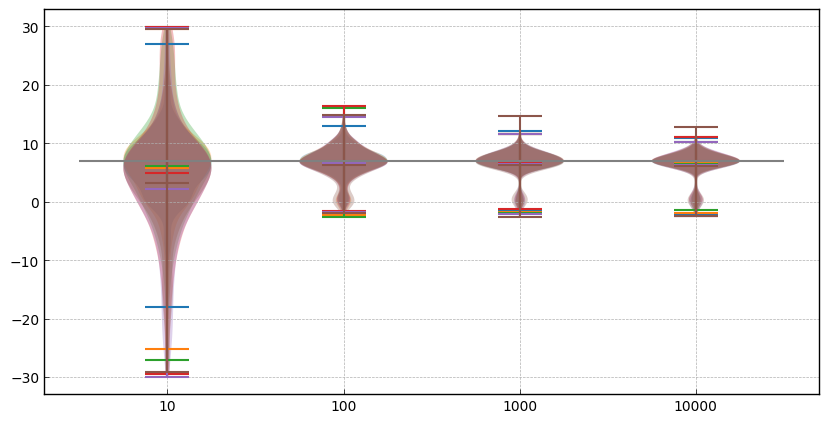

In [39]:
betas_list_list = []
for i in range(6):
    betas_list = []
    for j in range(4):
        betas = beta_estimated[:, j, i, 1]
        betas = betas[np.abs(betas) < 30]
        betas_list.append(betas)
    betas_list_list.append(betas_list)

plt.figure(figsize=(10, 5))
for i in range(6):
    plt.violinplot(betas_list_list[i], showmeans=True, showmedians=False)
    
plt.hlines(beta_true[1], 0.5, 4.5, color='grey', label='True')
plt.xticks([1, 2, 3, 4], n0_candidates)
plt.grid(True, linestyle='--', linewidth=0.5)

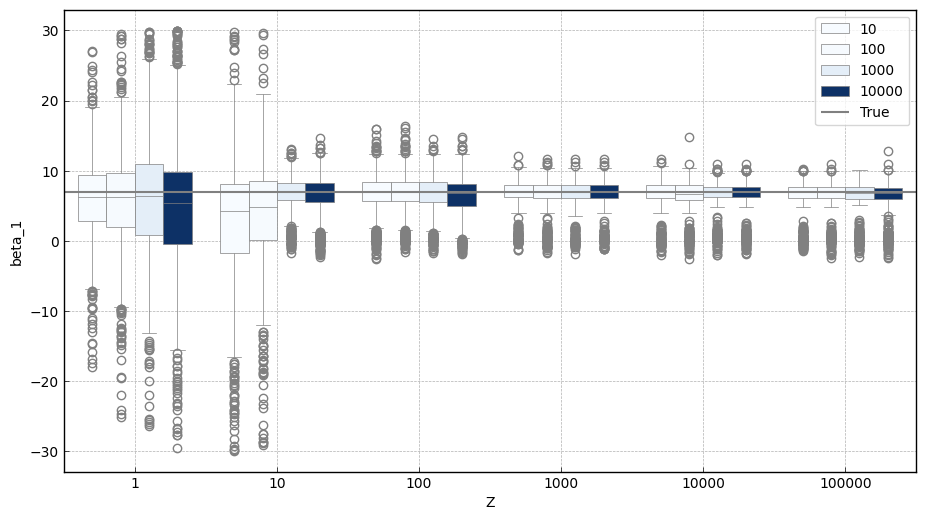

In [66]:
beta_df = pd.DataFrame(beta_estimated.reshape(-1, 3), columns=['alpha', 'beta_1', 'beta_2'])
beta_df['n0'] = np.tile(n0_candidates, 6000)
beta_df['Z'] = np.tile(np.repeat(Z_candidates, 4), 1000)

beta_df = beta_df[beta_df['alpha'].abs() < 30]
beta_df = beta_df[beta_df['beta_1'].abs() < 30]
beta_df = beta_df[beta_df['beta_2'].abs() < 30]

plt.figure(figsize=(11, 6))
sns.boxplot(x='Z', y='beta_1', data=beta_df, hue='n0', palette='Blues', saturation=0.9, linewidth=0.5, linecolor='grey')
plt.hlines(beta_true[1], -1, 6, color='grey', label='True')
plt.xlim(-0.5, 5.5)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)  

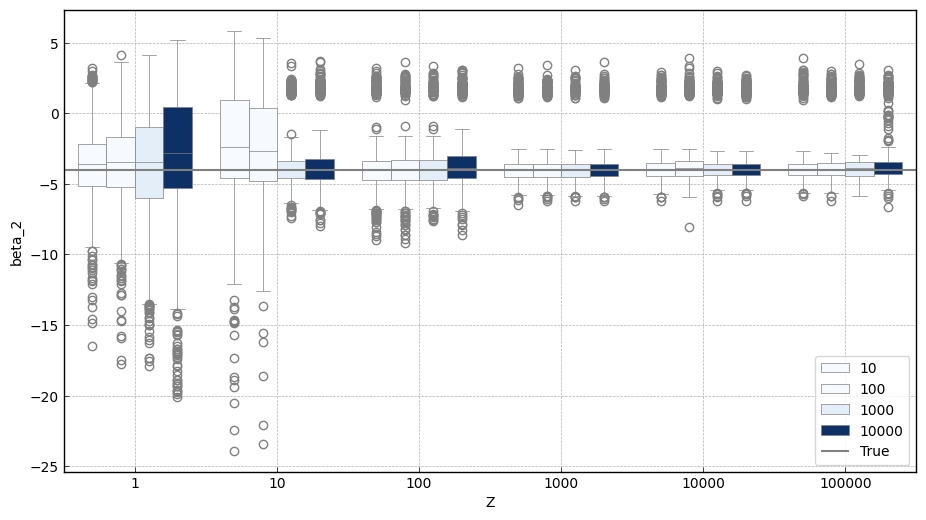

In [68]:
beta_df = pd.DataFrame(beta_estimated.reshape(-1, 3), columns=['alpha', 'beta_1', 'beta_2'])
beta_df['n0'] = np.tile(n0_candidates, 6000)
beta_df['Z'] = np.tile(np.repeat(Z_candidates, 4), 1000)

beta_df = beta_df[beta_df['alpha'].abs() < 30]
beta_df = beta_df[beta_df['beta_1'].abs() < 30]
beta_df = beta_df[beta_df['beta_2'].abs() < 30]

plt.figure(figsize=(11, 6))
sns.boxplot(x='Z', y='beta_2', data=beta_df, hue='n0', palette='Blues', saturation=0.9, linewidth=0.5, linecolor='grey')
plt.hlines(beta_true[2], -1, 6, color='grey', label='True')
plt.xlim(-0.5, 5.5)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)  

In [41]:
beta_df

,alpha,beta_1,beta_2,n0,Z
0,3.525377,4.443085,-3.444857,10,1
1,2.309933,1.712174,-2.090906,100,1
2,1.366759,-1.143148,-0.814968,1000,1
3,1.064363,-4.587978,0.433157,10000,1
4,-0.136105,-6.166385,0.833543,10,10
...,...,...,...,...,...
23993,-14.714047,7.206776,-4.137298,100,10000
23994,0.696657,0.665907,1.763454,1000,10000
23995,-7.414116,5.182205,-2.942134,10000,10000
23996,-9.716407,5.181431,-2.941756,10,100000


## ベイズ推定

In [207]:
# 平均ベクトルと共分散行列の設定
b = np.zeros(3)
B = np.diag(np.ones(3))

# Peform Gibbs sampling for T iterations.
pg         = PyPolyaGamma()
SIM          = 10000
Omega_diag = np.ones(len(t1)+n0)
beta_hat   = npr.multivariate_normal(b, B)
k          = y - z/2.

beta_list = []
for _ in tqdm(range(SIM)):
    # ω ~ PG(1, x*β).
    Omega_diag = multi_pgdraw(pg, z, X @ beta_hat)
    # β ~ N(m, V).
    V         = inv(X.T @ np.diag(Omega_diag) @ X + inv(B))
    m         = np.dot(V, X.T @ k + inv(B) @ b)
    beta_hat  = npr.multivariate_normal(m, V)
    beta_list.append(beta_hat)
    
beta_list = np.array(beta_list)

ValueError: operands could not be broadcast together with shapes (78,) (215,) 

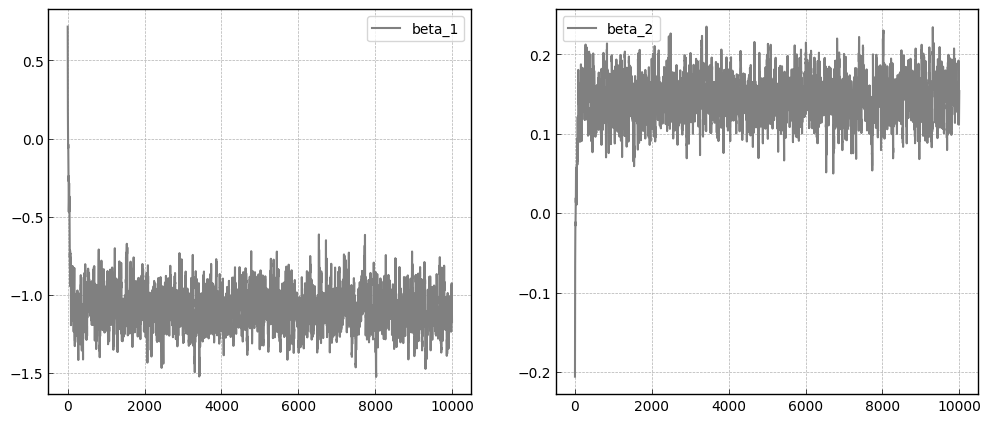

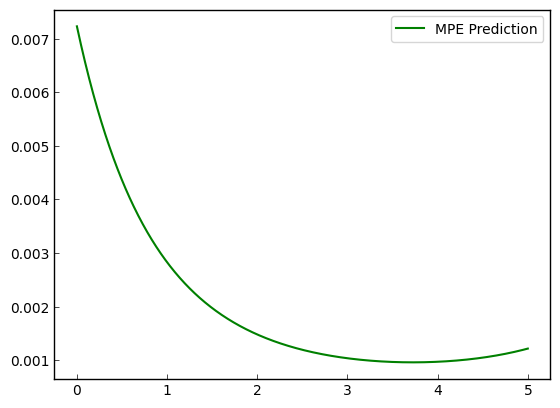

In [43]:
plt.figure(figsize=(12, 5))
#plt.title('Posterior Distribution of Beta')
# beta_list[:, 0]をTを横軸にしてプロット
plt.subplot(1, 2, 1)
plt.plot(beta_list[:, 1], c='grey', label='beta_1')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(beta_list[:, 2], c='grey', label='beta_2')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()

plt.show()

beta_mpe = beta_list[15:].mean(axis=0)

x_lin = np.linspace(0, T, 1000)
intensity = lamda(x_lin, beta_mpe)
plt.plot(x_lin, intensity, c='green', label='MPE Prediction')
plt.legend()
plt.show()